In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from imblearn.datasets import make_imbalance
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import EditedNearestNeighbours, NearMiss
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from imblearn.metrics import geometric_mean_score

In [2]:
def create_dataset(n_samples=5000, weights = (0.5,0.5), n_classes=2,
                   class_sep=0.01, n_clusters = 2):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes, flip_y = 0.1,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)

In [3]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

In [4]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [5]:
#Membuat toy dataset

from sklearn.model_selection import train_test_split
X, y = create_dataset (n_samples=5000, weights = (0.9, 0.1), class_sep=0.5)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

# X_train = X_train.values
# y_train = y_train.values
# X_test = X_test.values
# y_test = y_test.values
print ("Komponen dataset sebelum undersampling = {}" .format(Counter(y)))

#Undersampling Dataset
sampler = EditedNearestNeighbours(random_state = 0 , sampling_strategy='all')
# sampler = NearMiss()
X_enn, y_enn = sampler.fit_resample (X_train , y_train)

#Train dataset dengan classifier
clf_logreg = LogisticRegression(C=0.1, penalty='l1')
clf_logreg.fit(X_enn,y_enn)

clf_knn = KNeighborsClassifier(n_neighbors=3, algorithm='auto', metric='euclidean')
clf_knn.fit(X_enn, y_enn)

clf_svm = SVC(gamma=2, C=1)
clf_svm.fit(X_enn, y_enn)

clf_dt = DecisionTreeClassifier(max_depth=5)
clf_dt.fit(X_enn, y_enn)

clf_rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features='auto')
clf_rf.fit(X_enn, y_enn)

print ("Komponen dataset setelah undersampling = {}" .format(Counter(y_enn)))

print ("Komponen training set = {}" .format(Counter(y_train)))
print ("Komponen testing set = {}" .format(Counter(y_test)))



Komponen dataset sebelum undersampling = Counter({0: 4292, 1: 708})
Komponen dataset setelah undersampling = Counter({0: 2589, 1: 124})
Komponen training set = Counter({0: 3434, 1: 566})
Komponen testing set = Counter({0: 858, 1: 142})


C:\Users\Muhsin Ahadi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C:\Users\Muhsin Ahadi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


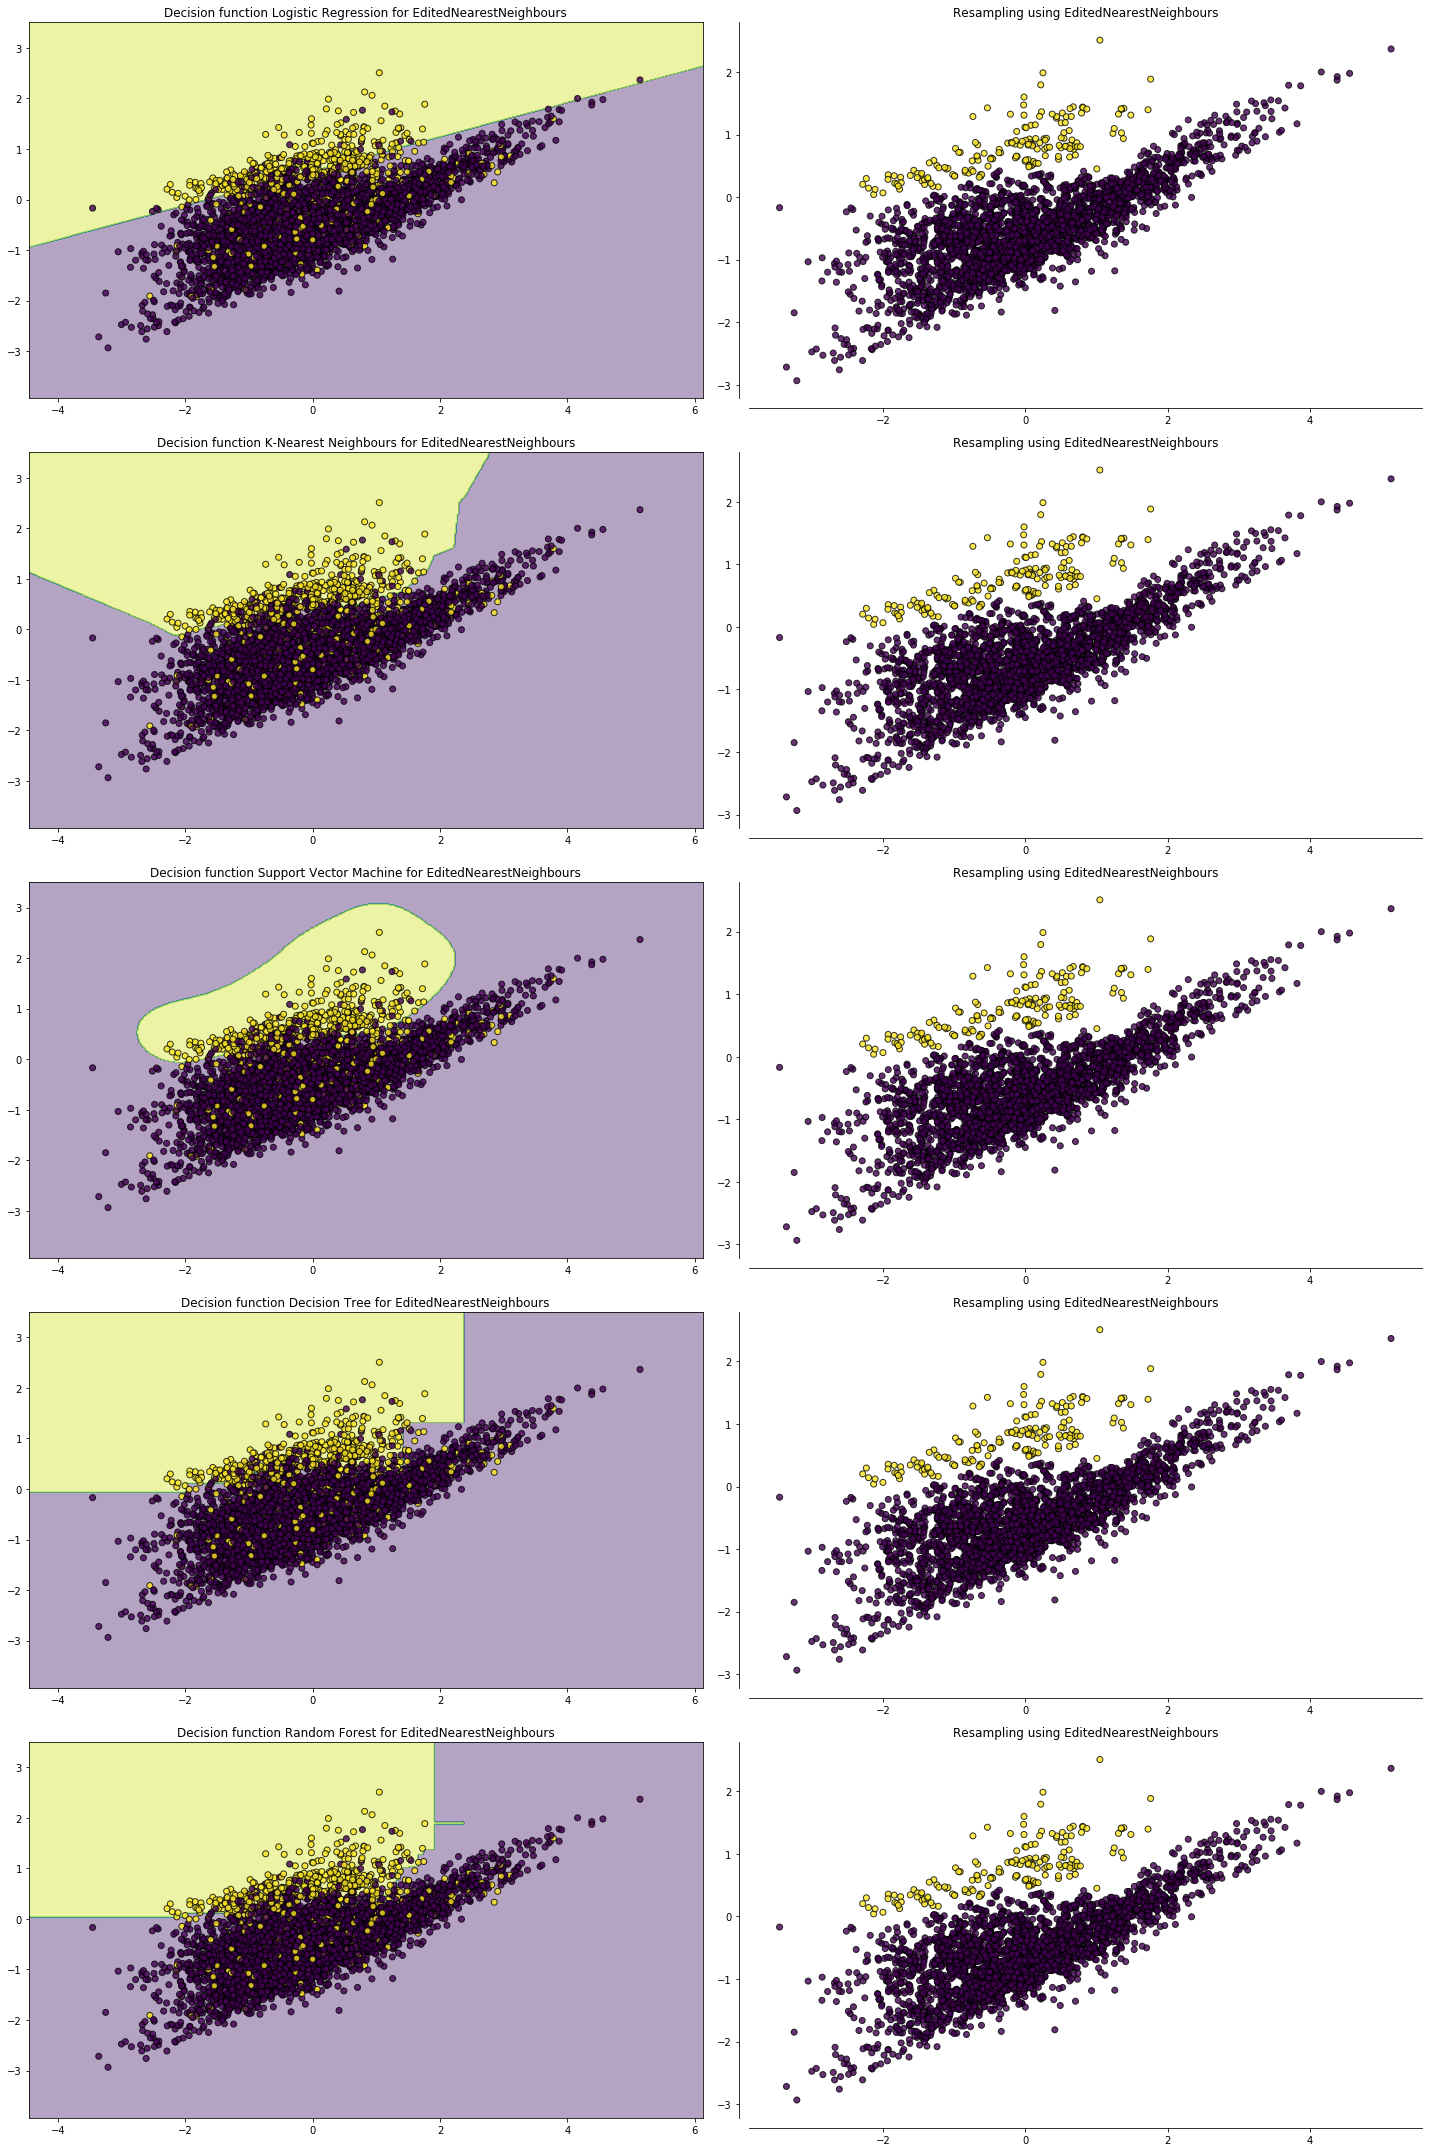

In [6]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5,2, figsize = (20,30))

# classifiers = [clf_logreg, clf_knn]
ax_arr = ((ax1,ax2), (ax3,ax4), (ax5,ax6), (ax7,ax8), (ax9,ax10))
names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]


for ax, name, classifier in zip (ax_arr, names,  (clf_logreg, clf_knn, clf_svm, clf_dt, clf_rf)):
    clf = make_pipeline (sampler, classifier)
    clf.fit(X,y)
    
    plot_decision_function(X, y, clf, ax[0])
    ax[0].set_title('Decision function {} for {}'.format(name,
        sampler.__class__.__name__))
    plot_resampling(X, y, sampler, ax[1])
    ax[1].set_title('Resampling using {}'.format(
        sampler.__class__.__name__))
fig.tight_layout()


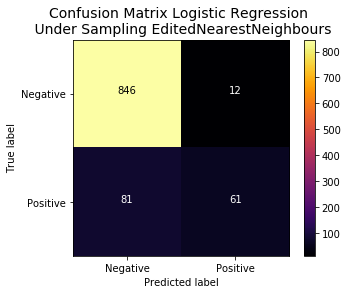

In [7]:
from sklearn.metrics import confusion_matrix

#Menerapkan confusion matrix pada testing set
y_pred_log_reg = clf_logreg.predict(X_test)


#log
#mengganti testing setnya dengan testing set untuk data keseluruhan
log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)

import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
labels = ['Negative', 'Positive']

fig = plt.figure(figsize=(5,4))

plot_confusion_matrix(log_reg_cf, labels, title="Confusion Matrix Logistic Regression \n Under Sampling {}" .format(sampler.__class__.__name__) , cmap=plt.cm.inferno)

In [8]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
##Logistic Regression
print ("Pengukuran Performa Training Set hasil ENN: \n")
y_pred_logreg = clf_logreg.predict(X_enn)

print ('Classification Report Logistic Regression:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn, y_pred_logreg)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn, y_pred_logreg)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn, y_pred_logreg)))

G_mean_under_sampling_enn = geometric_mean_score (y_enn, y_pred_logreg)

print ("G-Mean untuk Logistic Regresion with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn)

#KNearest Neighbor
y_pred_knn = clf_knn.predict(X_enn)

print ('\nClassification Report K Nearest Neighbor:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn, y_pred_knn)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn, y_pred_knn)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn, y_pred_knn)))

G_mean_under_sampling_enn = geometric_mean_score (y_enn, y_pred_knn)

print ("G-Mean untuk K Nearest Neighbor with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn)

#SVM
y_pred_svm = clf_svm.predict(X_enn)

print ('\nClassification Report Support Vector Machine:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn, y_pred_svm)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn, y_pred_svm)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn, y_pred_svm)))

G_mean_under_sampling_enn = geometric_mean_score (y_enn, y_pred_svm)

print ("G-Mean untuk Support Vector Machine with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn)

#Decision Tree
y_pred_dt = clf_dt.predict(X_enn)

print ('\nClassification Report Decision Tree:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn, y_pred_dt)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn, y_pred_dt)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn, y_pred_dt)))

G_mean_under_sampling_enn = geometric_mean_score (y_enn, y_pred_dt)

print ("G-Mean untuk Decision Tree with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn)

#Random Forest
y_pred_rf = clf_rf.predict(X_enn)

print ('\nClassification Report Random Forest:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn, y_pred_rf)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn, y_pred_rf)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn, y_pred_rf)))

G_mean_under_sampling_enn = geometric_mean_score (y_enn, y_pred_rf)

print ("G-Mean untuk Random Forest with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn)

Pengukuran Performa Training Set hasil ENN: 

Classification Report Logistic Regression:
Recall Score: 0.88
Precision Score: 0.98
F1 Score: 0.93
G-Mean untuk Logistic Regresion with EditedNearestNeighbours:  0.9372049970491918

Classification Report K Nearest Neighbor:
Recall Score: 0.98
Precision Score: 0.99
F1 Score: 0.98
G-Mean untuk K Nearest Neighbor with EditedNearestNeighbours:  0.9876383684538075

Classification Report Support Vector Machine:
Recall Score: 0.97
Precision Score: 1.00
F1 Score: 0.98
G-Mean untuk Support Vector Machine with EditedNearestNeighbours:  0.9837387536759294

Classification Report Decision Tree:
Recall Score: 1.00
Precision Score: 0.98
F1 Score: 0.99
G-Mean untuk Decision Tree with EditedNearestNeighbours:  0.9994204577896311

Classification Report Random Forest:
Recall Score: 1.00
Precision Score: 0.99
F1 Score: 1.00
G-Mean untuk Random Forest with EditedNearestNeighbours:  0.9998068565892174


In [9]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
print ("Pengukuran Performa terhadap Testing Set: \n")

##Logistic Regression
y_pred_logreg = clf_logreg.predict(X_test)

print ('Classification Report Logistic Regression:')
print('Recall Score: {:.2f}'.format(recall_score(y_test, y_pred_logreg)))
print('Precision Score: {:.2f}'.format(precision_score(y_test, y_pred_logreg)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred_logreg)))

G_mean_under_sampling_enn = geometric_mean_score (y_test, y_pred_logreg)

print ("G-Mean untuk Logistic Regresion with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn)

#KNearest Neighbor
y_pred_knn = clf_knn.predict(X_test)

print ('\nClassification Report K Nearest Neighbor:')
print('Recall Score: {:.2f}'.format(recall_score(y_test, y_pred_knn)))
print('Precision Score: {:.2f}'.format(precision_score(y_test, y_pred_knn)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred_knn)))

G_mean_under_sampling_enn = geometric_mean_score (y_test, y_pred_knn)

print ("G-Mean untuk K Nearest Neighbor with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn)

#SVM
y_pred_svm = clf_svm.predict(X_test)

print ('\nClassification Report Support Vector Machine:')
print('Recall Score: {:.2f}'.format(recall_score(y_test, y_pred_svm)))
print('Precision Score: {:.2f}'.format(precision_score(y_test, y_pred_svm)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred_svm)))

G_mean_under_sampling_enn = geometric_mean_score (y_test, y_pred_svm)

print ("G-Mean untuk Support Vector Machine with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn)

#Decision Tree
y_pred_dt = clf_dt.predict(X_test)

print ('\nClassification Report Decision Tree:')
print('Recall Score: {:.2f}'.format(recall_score(y_test, y_pred_dt)))
print('Precision Score: {:.2f}'.format(precision_score(y_test, y_pred_dt)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred_dt)))

G_mean_under_sampling_enn = geometric_mean_score (y_test, y_pred_dt)

print ("G-Mean untuk Decision Tree with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn)

#Random Forest
y_pred_rf = clf_rf.predict(X_test)

print ('\nClassification Report Random Forest:')
print('Recall Score: {:.2f}'.format(recall_score(y_test, y_pred_rf)))
print('Precision Score: {:.2f}'.format(precision_score(y_test, y_pred_rf)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred_rf)))

G_mean_under_sampling_enn = geometric_mean_score (y_test, y_pred_rf)

print ("G-Mean untuk Random Forest with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn)

Pengukuran Performa terhadap Testing Set: 

Classification Report Logistic Regression:
Recall Score: 0.43
Precision Score: 0.84
F1 Score: 0.57
G-Mean untuk Logistic Regresion with EditedNearestNeighbours:  0.6508220865629261

Classification Report K Nearest Neighbor:
Recall Score: 0.52
Precision Score: 0.84
F1 Score: 0.64
G-Mean untuk K Nearest Neighbor with EditedNearestNeighbours:  0.7159773227610172

Classification Report Support Vector Machine:
Recall Score: 0.52
Precision Score: 0.83
F1 Score: 0.64
G-Mean untuk Support Vector Machine with EditedNearestNeighbours:  0.7155530398658252

Classification Report Decision Tree:
Recall Score: 0.55
Precision Score: 0.81
F1 Score: 0.66
G-Mean untuk Decision Tree with EditedNearestNeighbours:  0.7333294532935806

Classification Report Random Forest:
Recall Score: 0.52
Precision Score: 0.82
F1 Score: 0.64
G-Mean untuk Random Forest with EditedNearestNeighbours:  0.715128505245325


In [10]:
#toy dataset gaussian quantile
from sklearn.datasets import make_gaussian_quantiles

X1, y1 = make_gaussian_quantiles (mean=(2,2), cov=2., n_samples=2000, n_features=2, n_classes=2, random_state=42, shuffle=True)

X_imb1, y_imb1 = make_imbalance (X1,y1, sampling_strategy={0:800, 1:200})
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_imb1, y_imb1, test_size = 0.2, random_state=42)

print ("Original Dataset = {}" .format(Counter(y1)))
print ("Komponen dataset setelah dibuat imbalance = {}" .format(Counter(y_imb1)))

#Undersampling Dataset
# sampler = NearMiss(sampling_strategy="majority", version=2)
sampler = EditedNearestNeighbours(random_state = 42 , sampling_strategy='majority')

X_enn1, y_enn1 = sampler.fit_resample (X_train1 , y_train1)

#Train dataset dengan classifier
clf_logreg1 = LogisticRegression(C=0.1, penalty='l1')
clf_logreg1.fit(X_enn1,y_enn1)

clf_knn1 = KNeighborsClassifier(n_neighbors=3, algorithm='auto', metric='euclidean')
clf_knn1.fit(X_enn1, y_enn1)

clf_svm1 = SVC(gamma=2, C=1)
clf_svm1.fit(X_enn1, y_enn1)

clf_dt1 = DecisionTreeClassifier(max_depth=5)
clf_dt1.fit(X_enn1, y_enn1)

clf_rf1 = RandomForestClassifier(max_depth=5, n_estimators=10, max_features='auto')
clf_rf1.fit(X_enn1, y_enn1)

print ("Komponen dataset setelah undersampling = {}" .format(Counter(y_enn1)))

print ("Komponen training set = {}" .format(Counter(y_train1)))
print ("Komponen testing set = {}" .format(Counter(y_test1)))


Original Dataset = Counter({1: 1000, 0: 1000})
Komponen dataset setelah dibuat imbalance = Counter({0: 800, 1: 200})
Komponen dataset setelah undersampling = Counter({0: 633, 1: 156})
Komponen training set = Counter({0: 644, 1: 156})
Komponen testing set = Counter({0: 156, 1: 44})


C:\Users\Muhsin Ahadi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C:\Users\Muhsin Ahadi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


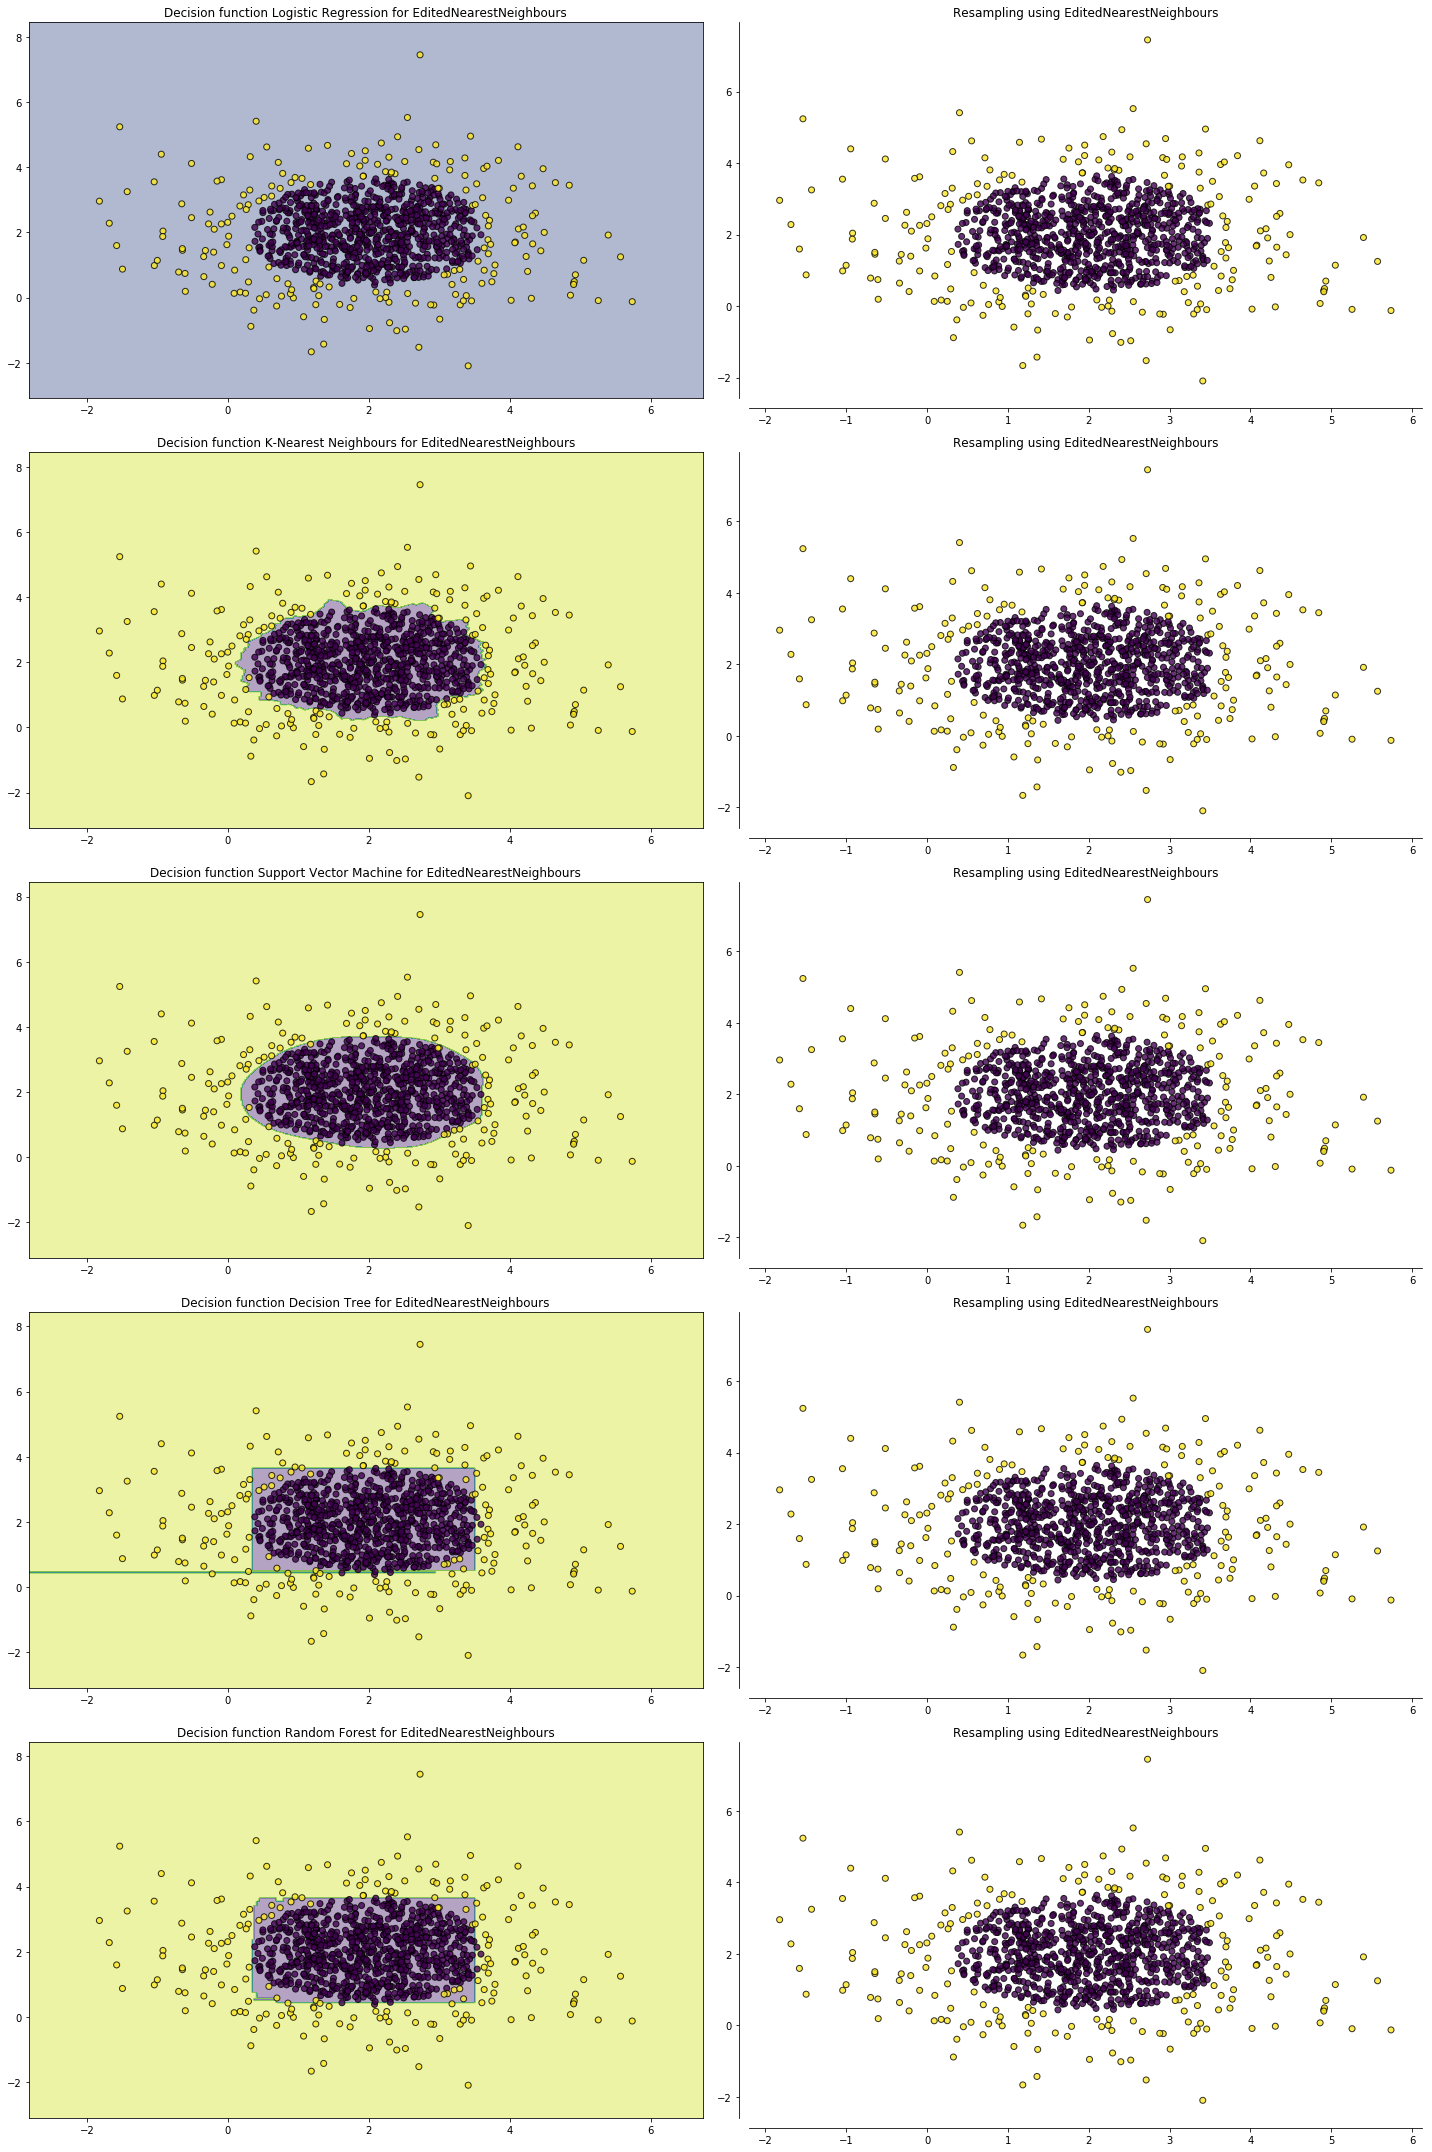

In [11]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5,2, figsize = (20,30))

# classifiers = [clf_logreg, clf_knn]
ax_arr = ((ax1,ax2), (ax3,ax4), (ax5,ax6), (ax7,ax8), (ax9,ax10))
names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]


for ax, name, classifier in zip (ax_arr, names,  (clf_logreg1, clf_knn1, clf_svm1, clf_dt1, clf_rf1)):
    clf = make_pipeline (sampler, classifier)
    clf.fit(X_imb1,y_imb1)
    
    plot_decision_function(X_imb1, y_imb1, clf, ax[0])
    ax[0].set_title('Decision function {} for {}'.format(name,
        sampler.__class__.__name__))
    plot_resampling(X_imb1, y_imb1, sampler, ax[1])
    ax[1].set_title('Resampling using {}'.format(
        sampler.__class__.__name__))
fig.tight_layout()

In [12]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

print ("Pengukuran Performa Training Set hasil ENN: \n")
y_pred_logreg1 = clf_logreg1.predict(X_enn1)

print ('Classification Report Logistic Regression:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn1, y_pred_logreg1)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn1, y_pred_logreg1, labels=np.unique(y_pred_logreg1))))
print('F1 Score: {:.2f}'.format(f1_score(y_enn1, y_pred_logreg1, labels=np.unique(y_pred_logreg1))))

G_mean_under_sampling_enn1 = geometric_mean_score (y_enn1, y_pred_logreg1)

print ("G-Mean untuk Logistic Regresion with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

#KNearest Neighbor
y_pred_knn1 = clf_knn1.predict(X_enn1)

print ('\nClassification Report K Nearest Neighbor:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn1, y_pred_knn1)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn1, y_pred_knn1)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn1, y_pred_knn1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_enn1, y_pred_knn1)

print ("G-Mean untuk K Nearest Neighbor with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

#SVM
y_pred_svm1 = clf_svm1.predict(X_enn1)

print ('\nClassification Report Support Vector Machine:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn1, y_pred_svm1)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn1, y_pred_svm1)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn1, y_pred_svm1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_enn1, y_pred_svm1)

print ("G-Mean untuk Support Vector Machine with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

#Decision Tree
y_pred_dt1 = clf_dt1.predict(X_enn1)

print ('\nClassification Report Decision Tree:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn1, y_pred_dt1)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn1, y_pred_dt1)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn1, y_pred_dt1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_enn1, y_pred_dt1)

print ("G-Mean untuk Decision Tree with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

#Random Forest
y_pred_rf1 = clf_rf1.predict(X_enn1)

print ('\nClassification Report Random Forest:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn1, y_pred_rf1)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn1, y_pred_rf1)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn1, y_pred_rf1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_enn1, y_pred_rf1)

print ("G-Mean untuk Random Forest with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

Pengukuran Performa Training Set hasil ENN: 

Classification Report Logistic Regression:
Recall Score: 0.00
Precision Score: 0.00
F1 Score: 0.00
G-Mean untuk Logistic Regresion with EditedNearestNeighbours:  0.0

Classification Report K Nearest Neighbor:
Recall Score: 0.97
Precision Score: 1.00
F1 Score: 0.99
G-Mean untuk K Nearest Neighbor with EditedNearestNeighbours:  0.9870962335856491

Classification Report Support Vector Machine:
Recall Score: 0.96
Precision Score: 1.00
F1 Score: 0.98
G-Mean untuk Support Vector Machine with EditedNearestNeighbours:  0.9805806756909202

Classification Report Decision Tree:
Recall Score: 0.92
Precision Score: 1.00
F1 Score: 0.96
G-Mean untuk Decision Tree with EditedNearestNeighbours:  0.9574271077563381

Classification Report Random Forest:
Recall Score: 0.92
Precision Score: 1.00
F1 Score: 0.96
G-Mean untuk Random Forest with EditedNearestNeighbours:  0.9574271077563381


In [13]:
print ("Pengukuran Performa terhadap Testing Set: \n")

##Logistic Regression
y_pred_logreg1 = clf_logreg1.predict(X_test1)

print ('Classification Report Logistic Regression:')
print('Recall Score: {:.2f}'.format(recall_score(y_test1, y_pred_logreg1)))
print('Precision Score: {:.2f}'.format(precision_score(y_test1, y_pred_logreg1)))
print('F1 Score: {:.2f}'.format(f1_score(y_test1, y_pred_logreg1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_test1, y_pred_logreg1)

print ("G-Mean untuk Logistic Regresion with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

#KNearest Neighbor
y_pred_knn1 = clf_knn1.predict(X_test1)

print ('\nClassification Report K Nearest Neighbor:')
print('Recall Score: {:.2f}'.format(recall_score(y_test1, y_pred_knn1)))
print('Precision Score: {:.2f}'.format(precision_score(y_test1, y_pred_knn1)))
print('F1 Score: {:.2f}'.format(f1_score(y_test1, y_pred_knn1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_test1, y_pred_knn1)

print ("G-Mean untuk K Nearest Neighbor with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

#SVM
y_pred_svm1 = clf_svm1.predict(X_test1)

print ('\nClassification Report Support Vector Machine:')
print('Recall Score: {:.2f}'.format(recall_score(y_test1, y_pred_svm1)))
print('Precision Score: {:.2f}'.format(precision_score(y_test1, y_pred_svm1)))
print('F1 Score: {:.2f}'.format(f1_score(y_test1, y_pred_svm1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_test1, y_pred_svm1)

print ("G-Mean untuk Support Vector Machine with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

#Decision Tree
y_pred_dt1 = clf_dt1.predict(X_test1)

print ('\nClassification Report Decision Tree:')
print('Recall Score: {:.2f}'.format(recall_score(y_test1, y_pred_dt1)))
print('Precision Score: {:.2f}'.format(precision_score(y_test1, y_pred_dt1)))
print('F1 Score: {:.2f}'.format(f1_score(y_test1, y_pred_dt1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_test1, y_pred_dt1)

print ("G-Mean untuk Decision Tree with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

#Random Forest
y_pred_rf1 = clf_rf1.predict(X_test1)

print ('\nClassification Report Random Forest:')
print('Recall Score: {:.2f}'.format(recall_score(y_test1, y_pred_rf1)))
print('Precision Score: {:.2f}'.format(precision_score(y_test1, y_pred_rf1)))
print('F1 Score: {:.2f}'.format(f1_score(y_test1, y_pred_rf1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_test1, y_pred_rf1)

print ("G-Mean untuk Random Forest with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

Pengukuran Performa terhadap Testing Set: 

Classification Report Logistic Regression:
Recall Score: 0.00
Precision Score: 0.00
F1 Score: 0.00
G-Mean untuk Logistic Regresion with EditedNearestNeighbours:  0.0

Classification Report K Nearest Neighbor:
Recall Score: 1.00
Precision Score: 0.98
F1 Score: 0.99
G-Mean untuk K Nearest Neighbor with EditedNearestNeighbours:  0.9967897188423162

Classification Report Support Vector Machine:
Recall Score: 0.91
Precision Score: 1.00
F1 Score: 0.95
G-Mean untuk Support Vector Machine with EditedNearestNeighbours:  0.9534625892455924

Classification Report Decision Tree:
Recall Score: 0.89
Precision Score: 1.00
F1 Score: 0.94
G-Mean untuk Decision Tree with EditedNearestNeighbours:  0.9414688716912718

Classification Report Random Forest:
Recall Score: 0.86
Precision Score: 1.00
F1 Score: 0.93
G-Mean untuk Random Forest with EditedNearestNeighbours:  0.9293203772845852


In [14]:
from sklearn.datasets import make_circles

X2, y2 = make_circles (n_samples=2000, shuffle=True, noise =0.08, factor=0.9)
X_imb2, y_imb2 = make_imbalance (X2, y2, sampling_strategy={0:800, 1:200})

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_imb2, y_imb2, test_size = 0.2, random_state=42)

print ("Original Dataset = {}" .format(Counter(y2)))
print ("Komponen dataset setelah imbalance = {}" .format(Counter(y_imb2)))

#Undersampling Dataset
# sampler = NearMiss(sampling_strategy="majority", version=2)
sampler = EditedNearestNeighbours(random_state = 42 , sampling_strategy='auto')

X_enn2, y_enn2 = sampler.fit_resample (X_train2 , y_train2)

#Train dataset dengan classifier
clf_logreg2 = LogisticRegression(C=0.1, penalty='l1')
clf_logreg2.fit(X_enn2,y_enn2)

clf_knn2 = KNeighborsClassifier(n_neighbors=3, algorithm='auto', metric='euclidean')
clf_knn2.fit(X_enn2, y_enn2)

clf_svm2 = SVC(gamma=2, C=1)
clf_svm2.fit(X_enn2, y_enn2)

clf_dt2 = DecisionTreeClassifier(max_depth=5)
clf_dt2.fit(X_enn2, y_enn2)

clf_rf2 = RandomForestClassifier(max_depth=5, n_estimators=9, max_features='auto')
clf_rf2.fit(X_enn2, y_enn2)

print ("Komponen dataset setelah undersampling = {}" .format(Counter(y_enn2)))

print ("Komponen training set = {}" .format(Counter(y_train2)))
print ("Komponen testing set = {}" .format(Counter(y_test2)))

Original Dataset = Counter({0: 1000, 1: 1000})
Komponen dataset setelah imbalance = Counter({0: 800, 1: 200})
Komponen dataset setelah undersampling = Counter({0: 446, 1: 156})
Komponen training set = Counter({0: 644, 1: 156})
Komponen testing set = Counter({0: 156, 1: 44})


C:\Users\Muhsin Ahadi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C:\Users\Muhsin Ahadi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


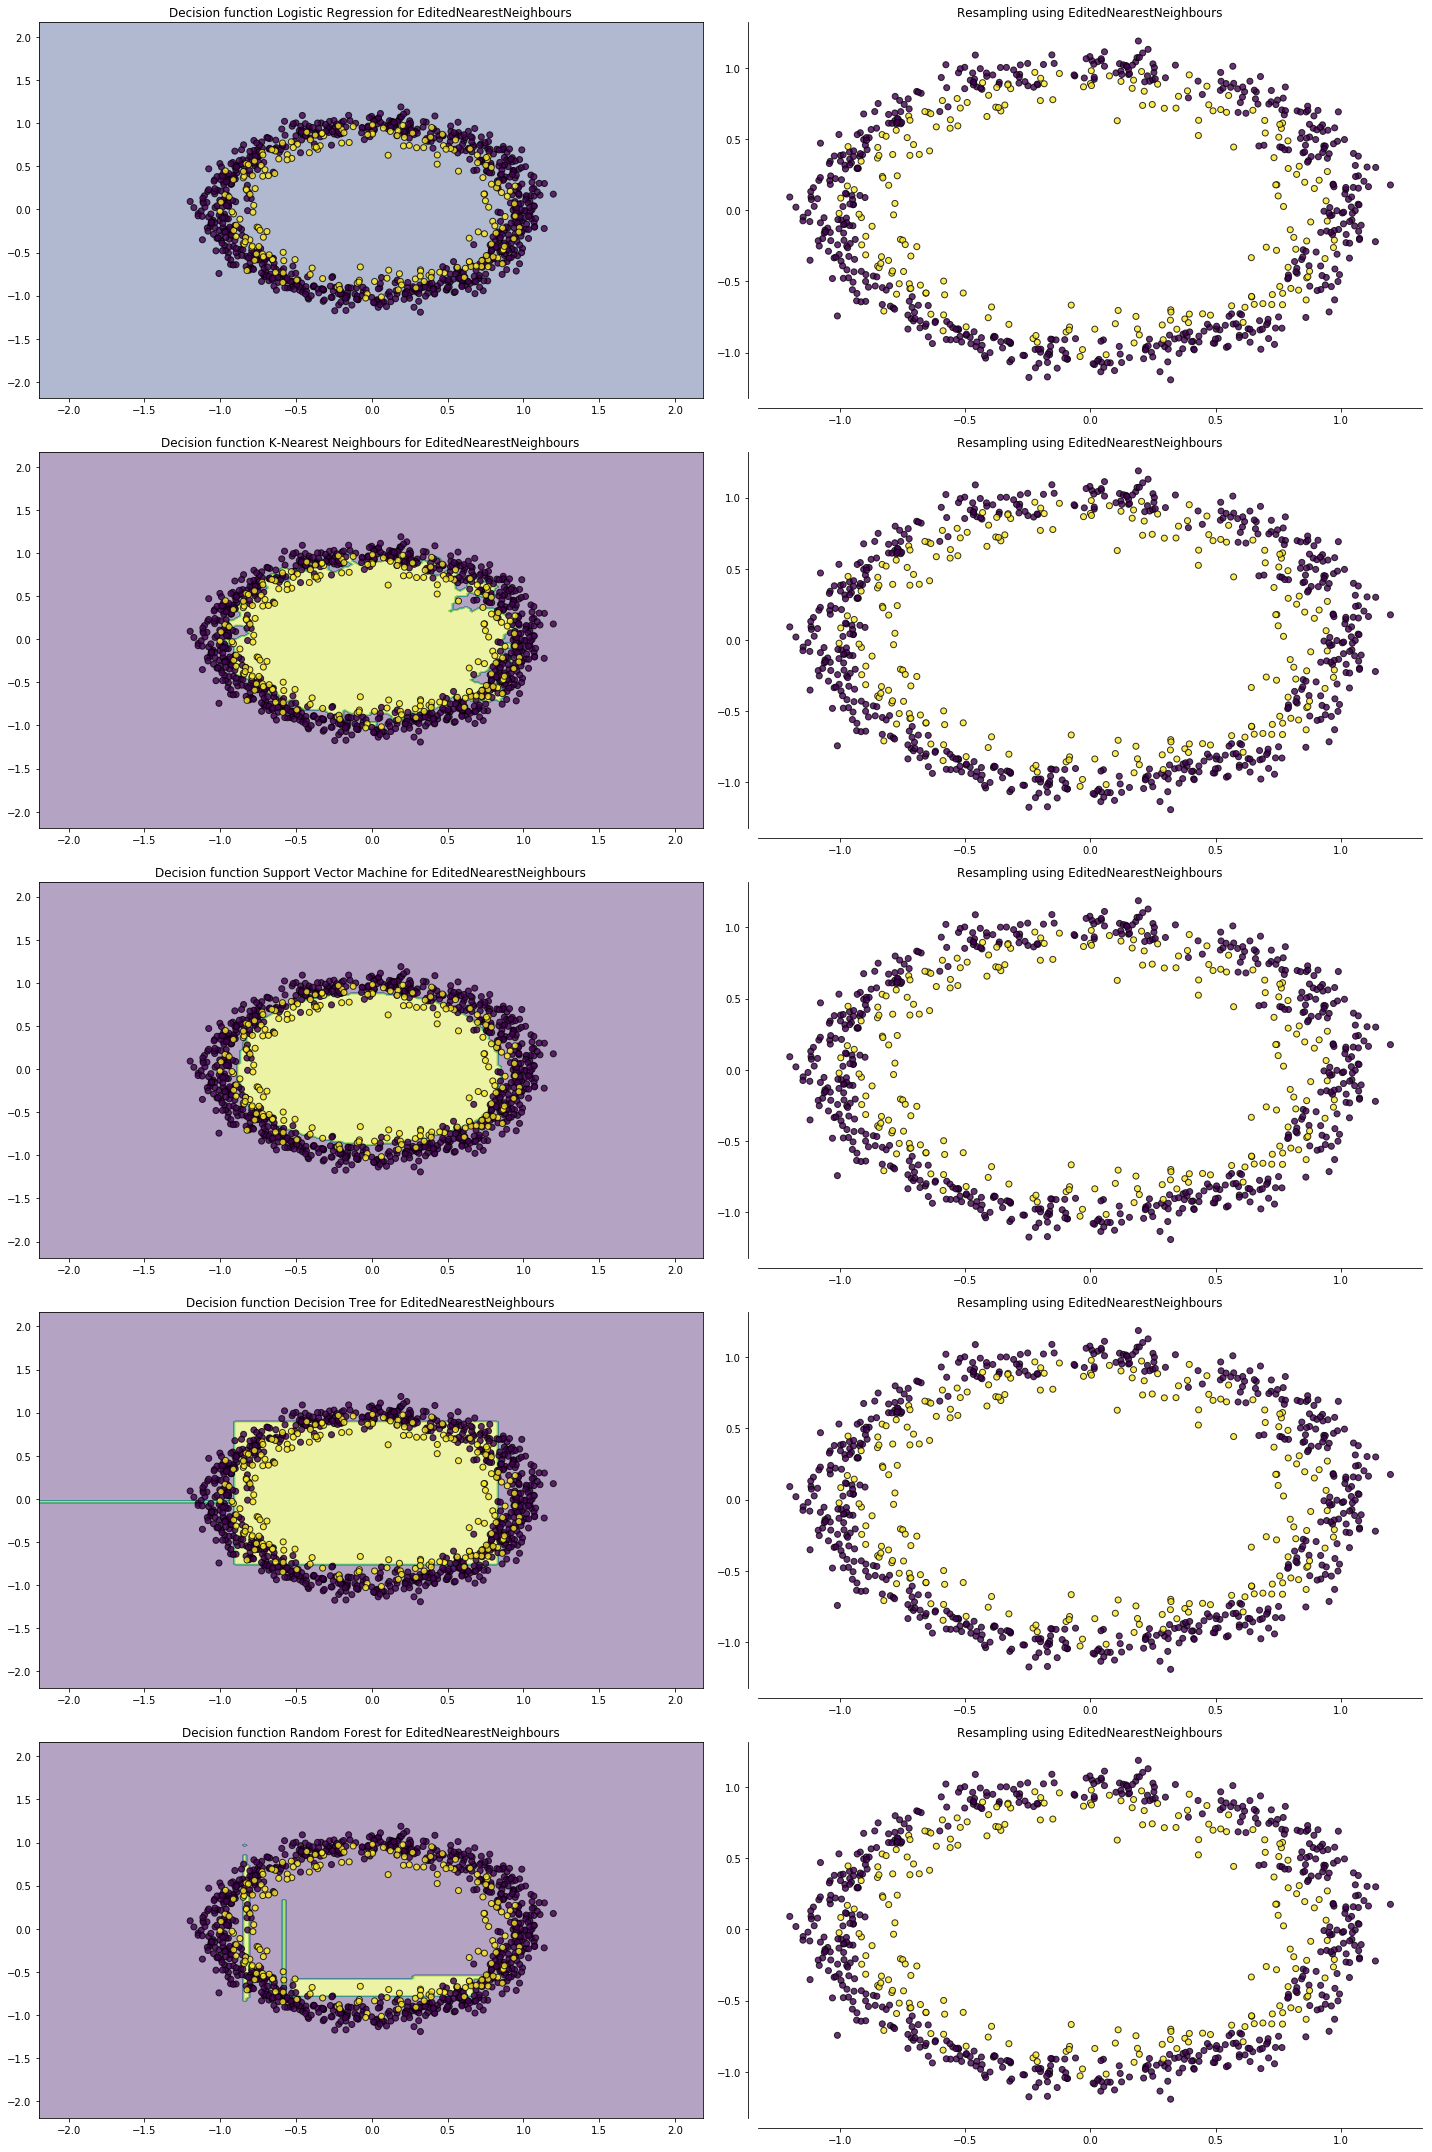

In [15]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5,2, figsize = (20,30))

# classifiers = [clf_logreg, clf_knn]
ax_arr = ((ax1,ax2), (ax3,ax4), (ax5,ax6), (ax7,ax8), (ax9,ax10))
names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]


for ax, name, classifier in zip (ax_arr, names,  (clf_logreg2, clf_knn2, clf_svm2, clf_dt2, clf_rf2)):
    clf = make_pipeline (sampler, classifier)
    clf.fit(X_imb2,y_imb2)
    
    plot_decision_function(X_imb2, y_imb2, clf, ax[0])
    ax[0].set_title('Decision function {} for {}'.format(name,
        sampler.__class__.__name__))
    plot_resampling(X_imb2, y_imb2, sampler, ax[1])
    ax[1].set_title('Resampling using {}'.format(
        sampler.__class__.__name__))
fig.tight_layout()

In [16]:
print ("Pengukuran Performa Training Set hasil ENN: \n")
y_pred_logreg2 = clf_logreg2.predict(X_enn2)

print ('Classification Report Logistic Regression:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn2, y_pred_logreg2)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn2, y_pred_logreg2)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn2, y_pred_logreg2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_enn2, y_pred_logreg2)

print ("G-Mean untuk Logistic Regresion with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

#KNearest Neighbor
y_pred_knn2 = clf_knn2.predict(X_enn2)

print ('\nClassification Report K Nearest Neighbor:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn2, y_pred_knn2)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn2, y_pred_knn2)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn2, y_pred_knn2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_enn2, y_pred_knn2)

print ("G-Mean untuk K Nearest Neighbor with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

#SVM
y_pred_svm2 = clf_svm2.predict(X_enn2)

print ('\nClassification Report Support Vector Machine:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn2, y_pred_svm2)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn2, y_pred_svm2)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn2, y_pred_svm2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_enn2, y_pred_svm2)

print ("G-Mean untuk Support Vector Machine with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

#Decision Tree
y_pred_dt2 = clf_dt2.predict(X_enn2)

print ('\nClassification Report Decision Tree:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn2, y_pred_dt2)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn2, y_pred_dt2)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn2, y_pred_dt2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_enn2, y_pred_dt2)

print ("G-Mean untuk Decision Tree with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

#Random Forest
y_pred_rf2 = clf_rf2.predict(X_enn2)

print ('\nClassification Report Random Forest:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn2, y_pred_rf2)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn2, y_pred_rf2)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn2, y_pred_rf2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_enn2, y_pred_rf2)

print ("G-Mean untuk Random Forest with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

Pengukuran Performa Training Set hasil ENN: 

Classification Report Logistic Regression:
Recall Score: 0.00
Precision Score: 0.00
F1 Score: 0.00
G-Mean untuk Logistic Regresion with EditedNearestNeighbours:  0.0

Classification Report K Nearest Neighbor:
Recall Score: 0.79
Precision Score: 0.95
F1 Score: 0.86
G-Mean untuk K Nearest Neighbor with EditedNearestNeighbours:  0.8845316436310062

Classification Report Support Vector Machine:
Recall Score: 0.49
Precision Score: 0.99
F1 Score: 0.66
G-Mean untuk Support Vector Machine with EditedNearestNeighbours:  0.7017713588689553

Classification Report Decision Tree:
Recall Score: 0.75
Precision Score: 0.56
F1 Score: 0.64
G-Mean untuk Decision Tree with EditedNearestNeighbours:  0.7726403394661734

Classification Report Random Forest:
Recall Score: 0.17
Precision Score: 0.74
F1 Score: 0.27
G-Mean untuk Random Forest with EditedNearestNeighbours:  0.40410820081645843


In [17]:
print ("Pengukuran Performa terhadap Testing Set: \n")

##Logistic Regression
y_pred_logreg2 = clf_logreg2.predict(X_test2)

print ('Classification Report Logistic Regression:')
print('Recall Score: {:.2f}'.format(recall_score(y_test2, y_pred_logreg2)))
print('Precision Score: {:.2f}'.format(precision_score(y_test2, y_pred_logreg2)))
print('F1 Score: {:.2f}'.format(f1_score(y_test2, y_pred_logreg2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_test2, y_pred_logreg2)

print ("G-Mean untuk Logistic Regresion with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

#KNearest Neighbor
y_pred_knn2 = clf_knn2.predict(X_test2)

print ('\nClassification Report K Nearest Neighbor:')
print('Recall Score: {:.2f}'.format(recall_score(y_test2, y_pred_knn2)))
print('Precision Score: {:.2f}'.format(precision_score(y_test2, y_pred_knn2)))
print('F1 Score: {:.2f}'.format(f1_score(y_test2, y_pred_knn2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_test2, y_pred_knn2)

print ("G-Mean untuk K Nearest Neighbor with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

#SVM
y_pred_svm2 = clf_svm2.predict(X_test2)

print ('\nClassification Report Support Vector Machine:')
print('Recall Score: {:.2f}'.format(recall_score(y_test2, y_pred_svm2)))
print('Precision Score: {:.2f}'.format(precision_score(y_test2, y_pred_svm2)))
print('F1 Score: {:.2f}'.format(f1_score(y_test2, y_pred_svm2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_test2, y_pred_svm2)

print ("G-Mean untuk Support Vector Machine with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

#Decision Tree
y_pred_dt2 = clf_dt2.predict(X_test2)

print ('\nClassification Report Decision Tree:')
print('Recall Score: {:.2f}'.format(recall_score(y_test2, y_pred_dt2)))
print('Precision Score: {:.2f}'.format(precision_score(y_test2, y_pred_dt2)))
print('F1 Score: {:.2f}'.format(f1_score(y_test2, y_pred_dt2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_test2, y_pred_dt2)

print ("G-Mean untuk Decision Tree with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

#Random Forest
y_pred_rf2 = clf_rf2.predict(X_test2)

print ('\nClassification Report Random Forest:')
print('Recall Score: {:.2f}'.format(recall_score(y_test2, y_pred_rf2)))
print('Precision Score: {:.2f}'.format(precision_score(y_test2, y_pred_rf2)))
print('F1 Score: {:.2f}'.format(f1_score(y_test2, y_pred_rf2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_test2, y_pred_rf2)

print ("G-Mean untuk Random Forest with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

Pengukuran Performa terhadap Testing Set: 

Classification Report Logistic Regression:
Recall Score: 0.00
Precision Score: 0.00
F1 Score: 0.00
G-Mean untuk Logistic Regresion with EditedNearestNeighbours:  0.0

Classification Report K Nearest Neighbor:
Recall Score: 0.84
Precision Score: 0.62
F1 Score: 0.71
G-Mean untuk K Nearest Neighbor with EditedNearestNeighbours:  0.8467165431411533

Classification Report Support Vector Machine:
Recall Score: 0.48
Precision Score: 0.70
F1 Score: 0.57
G-Mean untuk Support Vector Machine with EditedNearestNeighbours:  0.6706249042779147

Classification Report Decision Tree:
Recall Score: 0.73
Precision Score: 0.38
F1 Score: 0.50
G-Mean untuk Decision Tree with EditedNearestNeighbours:  0.6963106238227913

Classification Report Random Forest:
Recall Score: 0.30
Precision Score: 0.68
F1 Score: 0.41
G-Mean untuk Random Forest with EditedNearestNeighbours:  0.5330017908890261


In [18]:
from sklearn.datasets import make_moons

X3, y3 = make_moons (n_samples=2000, shuffle=True, noise =0.3)
X_imb3, y_imb3 = make_imbalance(X3, y3, sampling_strategy={0:800, 1:200})
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_imb3, y_imb3, test_size = 0.2, random_state=42)

print ("Original Dataset = {}" .format(Counter(y3)))
print ("Komponen dataset sebelum undersampling = {}" .format(Counter(y_imb3)))

#Undersampling Dataset
# sampler = NearMiss(sampling_strategy="majority", version=2)
sampler = EditedNearestNeighbours(random_state = 42 , sampling_strategy='majority')

X_enn3, y_enn3 = sampler.fit_resample (X_train2 , y_train2)

#Train dataset dengan classifier
clf_logreg3 = LogisticRegression(C=0.1, penalty='l1')
clf_logreg3.fit(X_enn3,y_enn3)

clf_knn3 = KNeighborsClassifier(n_neighbors=3, algorithm='auto', metric='euclidean')
clf_knn3.fit(X_enn3, y_enn3)

clf_svm3 = SVC(gamma=2, C=1)
clf_svm3.fit(X_enn3, y_enn3)

clf_dt3 = DecisionTreeClassifier(max_depth=5)
clf_dt3.fit(X_enn3, y_enn3)

clf_rf3 = RandomForestClassifier(max_depth=5, n_estimators=10, max_features='auto')
clf_rf3.fit(X_enn3, y_enn3)

print ("Komponen dataset setelah undersampling = {}" .format(Counter(y_enn3)))

print ("Komponen training set = {}" .format(Counter(y_train3)))
print ("Komponen testing set = {}" .format(Counter(y_test3)))

Original Dataset = Counter({0: 1000, 1: 1000})
Komponen dataset sebelum undersampling = Counter({0: 800, 1: 200})
Komponen dataset setelah undersampling = Counter({0: 446, 1: 156})
Komponen training set = Counter({0: 644, 1: 156})
Komponen testing set = Counter({0: 156, 1: 44})


C:\Users\Muhsin Ahadi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


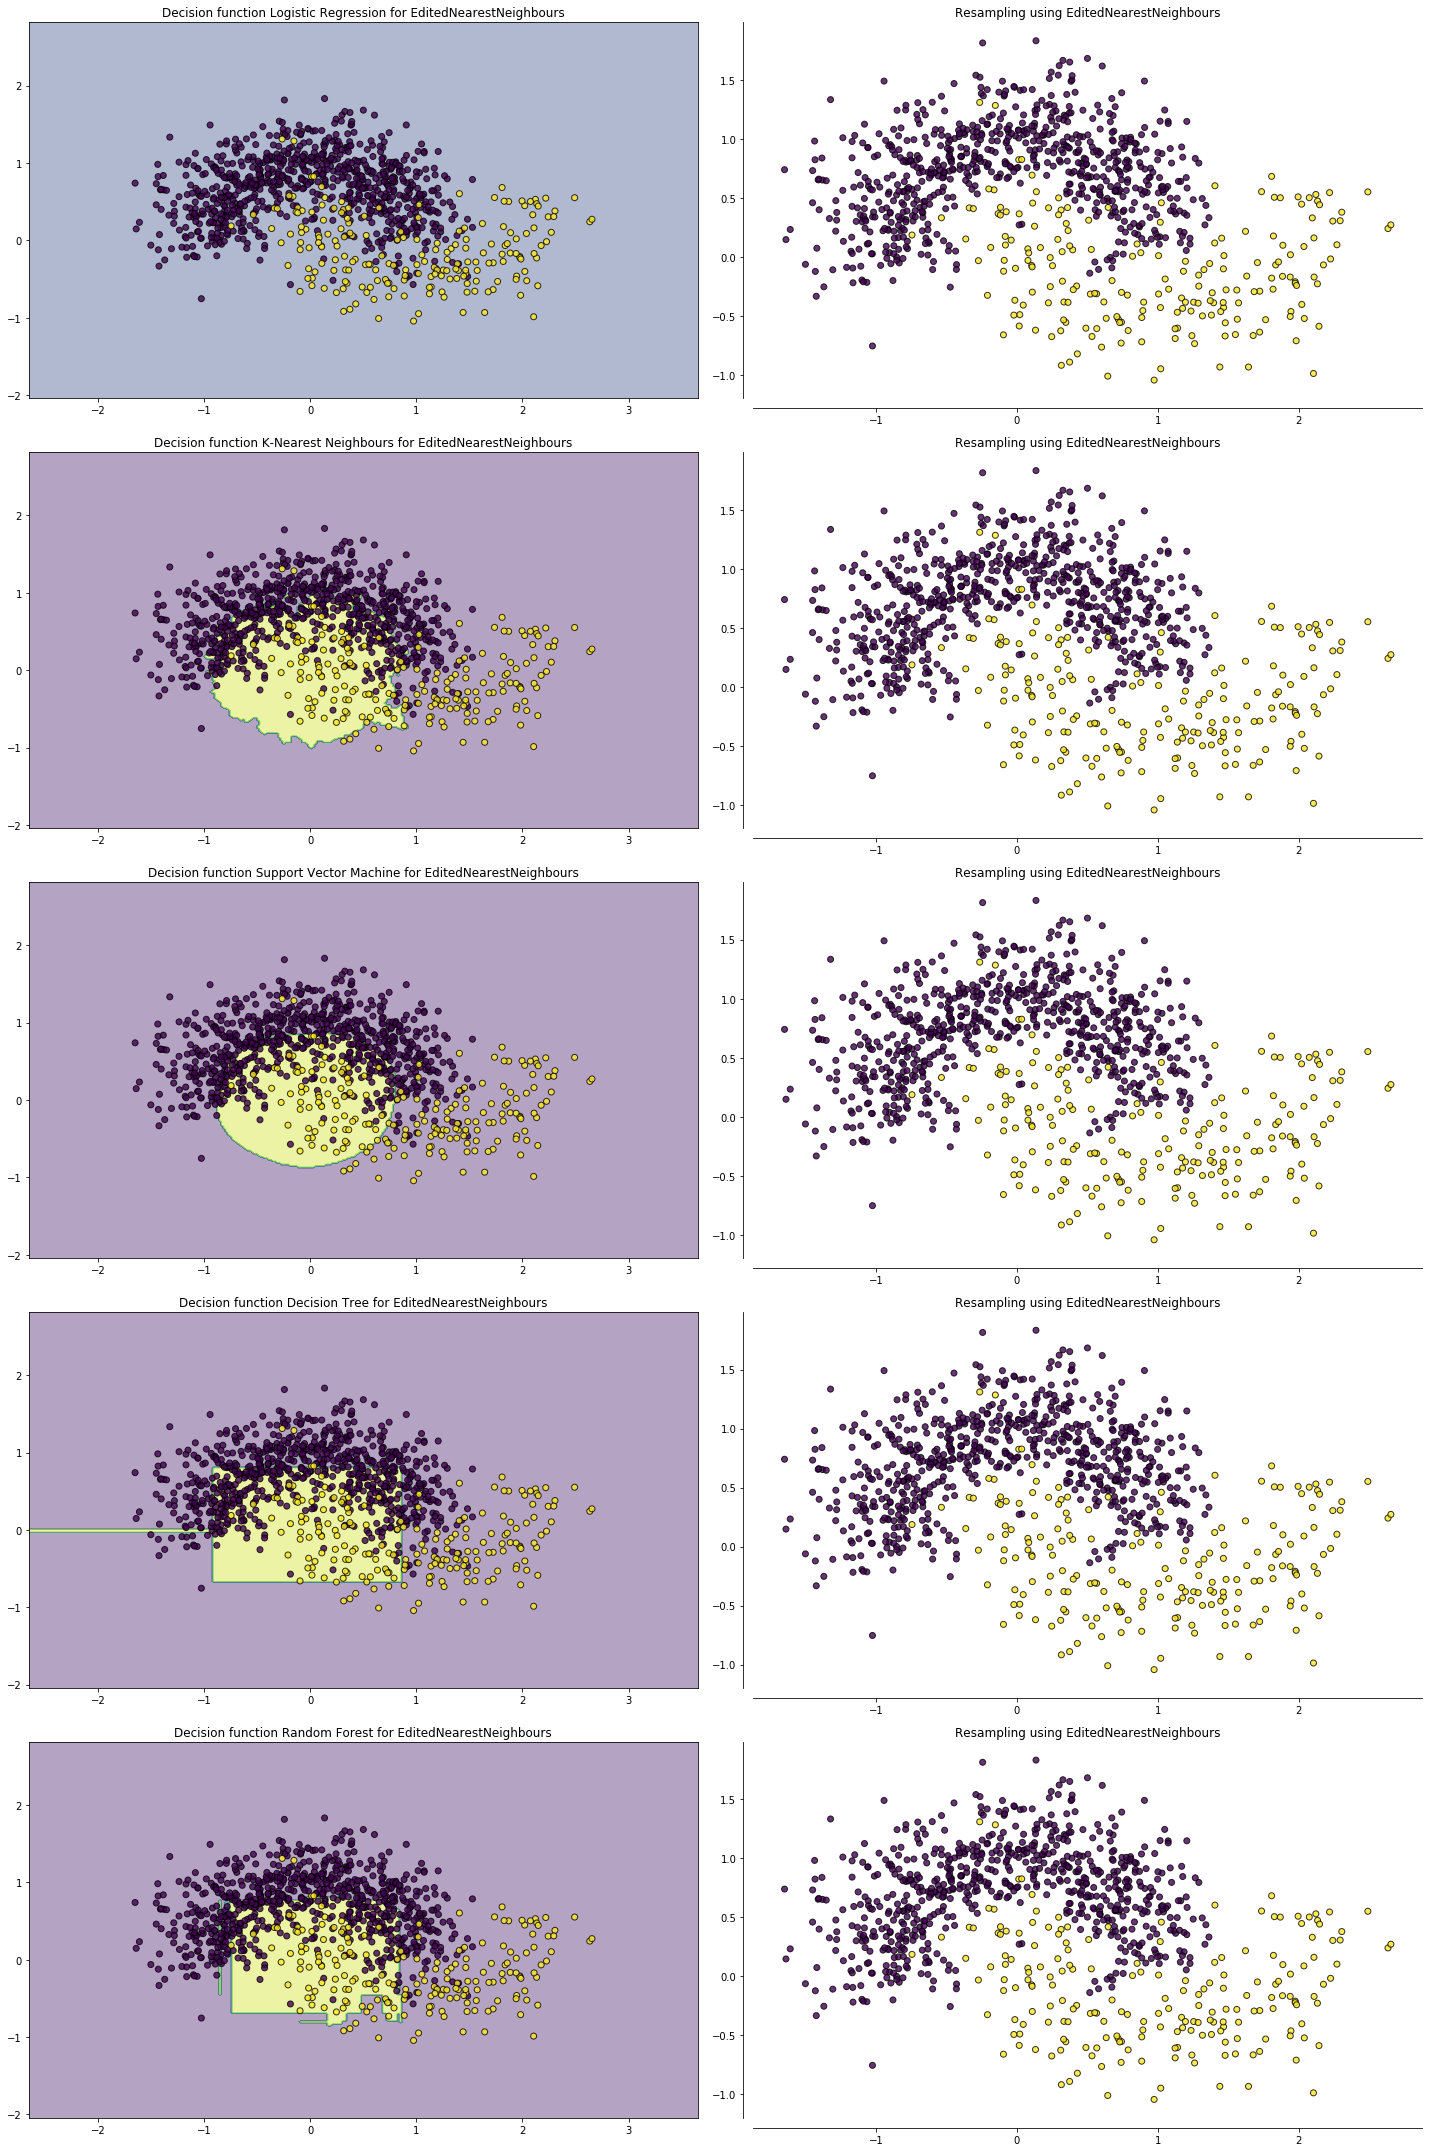

In [19]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5,2, figsize = (20,30))

# classifiers = [clf_logreg, clf_knn]
ax_arr = ((ax1,ax2), (ax3,ax4), (ax5,ax6), (ax7,ax8), (ax9,ax10))
names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]


for ax, name, classifier in zip (ax_arr, names,  (clf_logreg3, clf_knn3, clf_svm3, clf_dt3, clf_rf3)):
    clf = make_pipeline (sampler, classifier)    
    plot_decision_function(X_imb3, y_imb3, clf, ax[0])
    print (y_imb3.shape)
    ax[0].set_title('Decision function {} for {}'.format(name,
        sampler.__class__.__name__))
    plot_resampling(X_imb3, y_imb3, sampler, ax[1])
    ax[1].set_title('Resampling using {}'.format(
        sampler.__class__.__name__))
fig.tight_layout()

In [20]:
print ("Pengukuran Performa Training Set hasil ENN: \n")
y_pred_logreg3 = clf_logreg3.predict(X_enn3)

print ('Classification Report Logistic Regression:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn3, y_pred_logreg3)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn3, y_pred_logreg3)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn3, y_pred_logreg3)))

G_mean_under_sampling_enn3 = geometric_mean_score (y_enn3, y_pred_logreg3)

print ("G-Mean untuk Logistic Regresion with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn3)

#KNearest Neighbor
y_pred_knn3 = clf_knn3.predict(X_enn3)

print ('\nClassification Report K Nearest Neighbor:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn3, y_pred_knn3)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn3, y_pred_knn3)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn3, y_pred_knn3)))

G_mean_under_sampling_enn3 = geometric_mean_score (y_enn3, y_pred_knn3)

print ("G-Mean untuk K Nearest Neighbor with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn3)

#SVM
y_pred_svm3 = clf_svm3.predict(X_enn3)

print ('\nClassification Report Support Vector Machine:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn3, y_pred_svm3)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn3, y_pred_svm3)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn3, y_pred_svm3)))

G_mean_under_sampling_enn3 = geometric_mean_score (y_enn3, y_pred_svm3)

print ("G-Mean untuk Support Vector Machine with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn3)

#Decision Tree
y_pred_dt3 = clf_dt3.predict(X_enn3)

print ('\nClassification Report Decision Tree:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn3, y_pred_dt3)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn3, y_pred_dt3)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn3, y_pred_dt3)))

G_mean_under_sampling_enn3 = geometric_mean_score (y_enn3, y_pred_dt3)

print ("G-Mean untuk Decision Tree with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn3)

#Random Forest
y_pred_rf3 = clf_rf3.predict(X_enn3)

print ('\nClassification Report Random Forest:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn3, y_pred_rf3)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn3, y_pred_rf3)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn3, y_pred_rf3)))

G_mean_under_sampling_enn3 = geometric_mean_score (y_enn3, y_pred_rf3)

print ("G-Mean untuk Random Forest with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn3)

Pengukuran Performa Training Set hasil ENN: 

Classification Report Logistic Regression:
Recall Score: 0.00
Precision Score: 0.00
F1 Score: 0.00
G-Mean untuk Logistic Regresion with EditedNearestNeighbours:  0.0

Classification Report K Nearest Neighbor:
Recall Score: 0.78
Precision Score: 0.98
F1 Score: 0.87
G-Mean untuk K Nearest Neighbor with EditedNearestNeighbours:  0.8813573891553018

Classification Report Support Vector Machine:
Recall Score: 0.38
Precision Score: 0.97
F1 Score: 0.55
G-Mean untuk Support Vector Machine with EditedNearestNeighbours:  0.6187815866272589

Classification Report Decision Tree:
Recall Score: 0.71
Precision Score: 0.61
F1 Score: 0.66
G-Mean untuk Decision Tree with EditedNearestNeighbours:  0.7734769832840737

Classification Report Random Forest:
Recall Score: 0.54
Precision Score: 0.87
F1 Score: 0.67
G-Mean untuk Random Forest with EditedNearestNeighbours:  0.7273169058727817


In [21]:
print ("Pengukuran Performa terhadap Testing Set: \n")

##Logistic Regression
y_pred_logreg3 = clf_logreg3.predict(X_test3)

print ('Classification Report Logistic Regression:')
print('Recall Score: {:.2f}'.format(recall_score(y_test3, y_pred_logreg3)))
print('Precision Score: {:.2f}'.format(precision_score(y_test3, y_pred_logreg3)))
print('F1 Score: {:.2f}'.format(f1_score(y_test3, y_pred_logreg3)))

G_mean_under_sampling_enn3 = geometric_mean_score (y_test3, y_pred_logreg3)

print ("G-Mean untuk Logistic Regresion with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn3)

#KNearest Neighbor
y_pred_knn3 = clf_knn3.predict(X_test3)

print ('\nClassification Report K Nearest Neighbor:')
print('Recall Score: {:.2f}'.format(recall_score(y_test3, y_pred_knn3)))
print('Precision Score: {:.2f}'.format(precision_score(y_test3, y_pred_knn3)))
print('F1 Score: {:.2f}'.format(f1_score(y_test3, y_pred_knn3)))

G_mean_under_sampling_enn3 = geometric_mean_score (y_test3, y_pred_knn3)

print ("G-Mean untuk K Nearest Neighbor with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn3)

#SVM
y_pred_svm3 = clf_svm3.predict(X_test3)

print ('\nClassification Report Support Vector Machine:')
print('Recall Score: {:.2f}'.format(recall_score(y_test3, y_pred_svm3)))
print('Precision Score: {:.2f}'.format(precision_score(y_test3, y_pred_svm3)))
print('F1 Score: {:.2f}'.format(f1_score(y_test3, y_pred_svm3)))

G_mean_under_sampling_enn3 = geometric_mean_score (y_test3, y_pred_svm3)

print ("G-Mean untuk Support Vector Machine with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn3)

#Decision Tree
y_pred_dt3 = clf_dt3.predict(X_test3)

print ('\nClassification Report Decision Tree:')
print('Recall Score: {:.2f}'.format(recall_score(y_test3, y_pred_dt3)))
print('Precision Score: {:.2f}'.format(precision_score(y_test3, y_pred_dt3)))
print('F1 Score: {:.2f}'.format(f1_score(y_test3, y_pred_dt3)))

G_mean_under_sampling_enn3 = geometric_mean_score (y_test3, y_pred_dt3)

print ("G-Mean untuk Decision Tree with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn3)

#Random Forest
y_pred_rf3 = clf_rf3.predict(X_test3)

print ('\nClassification Report Random Forest:')
print('Recall Score: {:.2f}'.format(recall_score(y_test3, y_pred_rf3)))
print('Precision Score: {:.2f}'.format(precision_score(y_test3, y_pred_rf3)))
print('F1 Score: {:.2f}'.format(f1_score(y_test3, y_pred_rf3)))

G_mean_under_sampling_enn3 = geometric_mean_score (y_test3, y_pred_rf3)

print ("G-Mean untuk Random Forest with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn3)

Pengukuran Performa terhadap Testing Set: 

Classification Report Logistic Regression:
Recall Score: 0.00
Precision Score: 0.00
F1 Score: 0.00
G-Mean untuk Logistic Regresion with EditedNearestNeighbours:  0.0

Classification Report K Nearest Neighbor:
Recall Score: 0.39
Precision Score: 0.22
F1 Score: 0.28
G-Mean untuk K Nearest Neighbor with EditedNearestNeighbours:  0.482502702385031

Classification Report Support Vector Machine:
Recall Score: 0.36
Precision Score: 0.25
F1 Score: 0.30
G-Mean untuk Support Vector Machine with EditedNearestNeighbours:  0.5040627481566695

Classification Report Decision Tree:
Recall Score: 0.36
Precision Score: 0.19
F1 Score: 0.25
G-Mean untuk Decision Tree with EditedNearestNeighbours:  0.45547690112585015

Classification Report Random Forest:
Recall Score: 0.27
Precision Score: 0.18
F1 Score: 0.22
G-Mean untuk Random Forest with EditedNearestNeighbours:  0.42434647408683634
